## Sentiment Analysis On Twitter

## Data Source

The data for this analysis is sourced from the 'Twitter Entity Sentiment Analysis' dataset. It was obtained from the Kaggle dataset available at: https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis

In [ ]:
# Cell 1: Import Libraries
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
# nltk.download('stopwords')

In [ ]:
# Cell 2: Load Dataset
df = pd.read_csv("../data/twitter_training.csv", header=None, names=["ID", "Entity", "Sentiment", "Tweet"])
#   Check for missing values
print('Missing values in DataFrame:')
print(df.isnull().sum())

#   Handle missing values
if df.isnull().sum().sum() > 0:  # Check if there are any missing values at all
    if df['Tweet'].isnull().any():
        df['Tweet'] = df['Tweet'].fillna('')  # Fill missing tweets with empty string
        print("\nMissing 'Tweet' values filled with empty string.")
    if df['Sentiment'].isnull().any():
        df['Sentiment'] = df['Sentiment'].fillna(df['Sentiment'].mode()[0])  # Fill missing sentiment with mode
        print("Missing 'Sentiment' values filled with mode.")
else:
    print("\nNo missing values to handle.")
df.head()

Missing values in DataFrame:
ID             0
Entity         0
Sentiment      0
Tweet        686
dtype: int64

Missing 'Tweet' values filled with empty string.


,ID,Entity,Sentiment,Tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [ ]:
#   Cell 3: Clean the Text
def clean_text(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', text) # remove urls
    text = re.sub(r'\[.*?\]', '', text) # remove brackets
    text = re.sub(r'\'\"\"', '', text)
    text = re.sub(r'\n', '', text) # remove new line characters
    text = re.sub(r'\w*\d\w*', '', text) # remove words containing numbers
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text) # remove punctuation
    text = re.sub(r'“[^”]*”', '', text)
    text = re.sub(r'’[^’]*’', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text) # Keep only letters and spaces
    text = text.lower() # lowercase
    text = ' '.join(word for word in text.split() if word not in stop) # remove stop words
    text = ' '.join(word for word in text.split() if len(word)>1) #remove words with length 1
    return text

import string
stop = stopwords.words('english')
# Remove rows with missing Tweet values
df['Tweet'] = df['Tweet'].astype(str)

# Apply the cleaning function
df["cleaned_tweet"] = df["Tweet"].apply(clean_text)

In [ ]:
# Cell 4: Feature Engineering
df["text_length"] = df["cleaned_tweet"].apply(len)
df["word_count"] = df["cleaned_tweet"].apply(lambda x: len(x.split()))
df["has_hashtag"] = df["Tweet"].apply(lambda x: 1 if "#" in x else 0)
df["has_mention"] = df["Tweet"].apply(lambda x: 1 if "@" in x else 0)

In [ ]:
#   Cell 5: Summary Statistics
print('\nSummary Statistics for Numerical Features')
print(df.describe())

print('\nValue Counts for Sentiment Labels')
print(df['Sentiment'].value_counts())


Summary Statistics for Numerical Features
                 ID
count  74682.000000
mean    6432.586165
std     3740.427870
min        1.000000
25%     3195.000000
50%     6422.000000
75%     9601.000000
max    13200.000000

Value Counts for Sentiment Labels
Sentiment
Negative      22542
Positive      20832
Neutral       18318
Irrelevant    12990
Name: count, dtype: int64


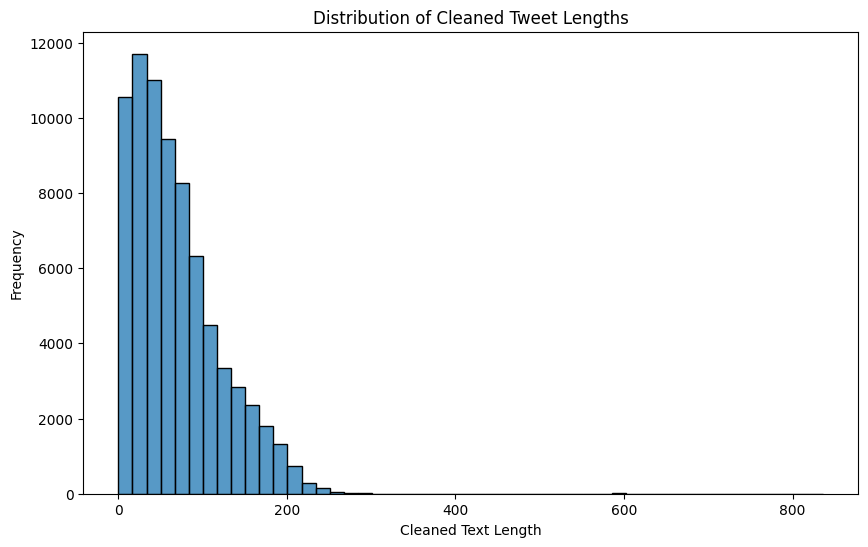

In [33]:
#   Cell 6: (New cell - add after the Summary Statistics cell)
#   Code cell

import matplotlib.pyplot as plt
import seaborn as sns

#   Visualization of text length
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=50)
plt.title('Distribution of Cleaned Tweet Lengths')
plt.xlabel('Cleaned Text Length')
plt.ylabel('Frequency')
plt.savefig("../outputs/visualizations/text_length_distribution.png")
plt.show()

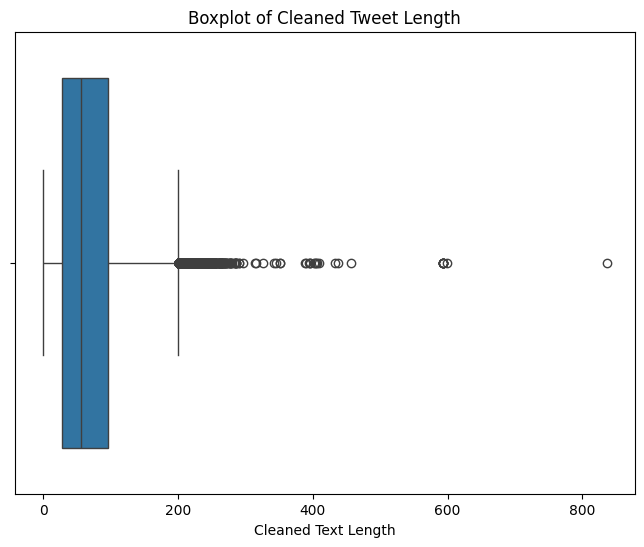


Number of potential outliers in text_length: 1270
Percentage of potential outliers: 1.70%

Outlier handling: For this analysis, we will keep the outliers as they might represent genuine long-form opinions. However, in a modeling context, you might consider removing or transforming them.


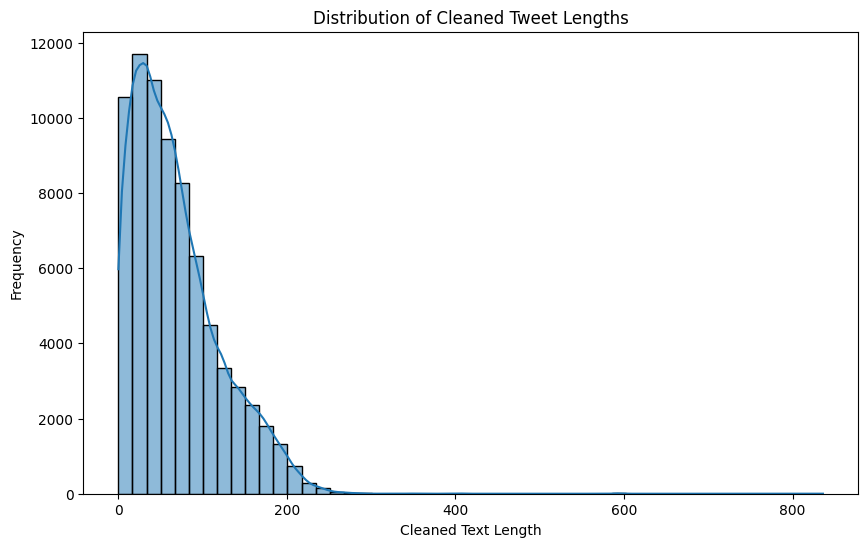


Log transformation not applied as there are text lengths equal to zero.


In [34]:
#   Cell 7: Handling Outliers and Data Transformation

#   Boxplot to visualize potential outliers in text_length
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['text_length'])
plt.title('Boxplot of Cleaned Tweet Length')
plt.xlabel('Cleaned Text Length')
plt.savefig("../outputs/visualizations/text_length_boxplot.png")
plt.show()

#   Identify potential outliers (using IQR method)
Q1 = df['text_length'].quantile(0.25)
Q3 = df['text_length'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['text_length'] < lower_bound) | (df['text_length'] > upper_bound)]
print(f'\nNumber of potential outliers in text_length: {len(outliers)}')
print(f'Percentage of potential outliers: {len(outliers) / len(df) * 100:.2f}%')

#   For this example, we will not remove outliers, but we acknowledge their presence.
print("\nOutlier handling: For this analysis, we will keep the outliers as they might represent genuine long-form opinions. However, in a modeling context, you might consider removing or transforming them.")

#   Consider Data Transformation (Log Transformation for skewed data)
#   Let's check the distribution again to see if it's skewed
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=50, kde=True)
plt.title('Distribution of Cleaned Tweet Lengths')
plt.xlabel('Cleaned Text Length')
plt.ylabel('Frequency')
plt.savefig("../outputs/visualizations/text_length_distribution_again.png")
plt.show()

#   Apply log transformation if the distribution is heavily skewed
import numpy as np
if df['text_length'].min() > 0: # Avoid log of zero
    df['log_text_length'] = np.log(df['text_length'])
    plt.figure(figsize=(10, 6))
    sns.histplot(df['log_text_length'], bins=50, kde=True)
    plt.title('Distribution of Log Transformed Tweet Lengths')
    plt.xlabel('Log of Cleaned Text Length')
    plt.ylabel('Frequency')
    plt.savefig("../outputs/visualizations/log_text_length_distribution.png")
    plt.show()
    print("\nLog transformation applied to text_length.")
else:
    print("\nLog transformation not applied as there are text lengths equal to zero.")

In [ ]:
# Cell 8: Save Cleaned Data
df.to_csv("../data/cleaned_data.csv", index=False)
print("✅ Cleaned data saved to ../data/cleaned_data.csv")

✅ Cleaned data saved to ../data/cleaned_data.csv
